In [10]:
import os
import itertools
import glob
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.ticker
import matplotlib.pyplot as plt


sns.set(font_scale=0.9, style='whitegrid', font='CMU Sans Serif')
pal = sns.color_palette(['#4477AA', '#EE6677', '#228833', '#CCBB44', '#66CCEE', '#AA3377', '#BBBBBB'])
sns.set_palette(pal)

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['figure.figsize'] = (4.5,2)
mpl.rcParams['figure.dpi'] = 100

In [11]:
RESET_LOGS = "../reset-logs/logs-class,vessel,wildfire,multiclass-2000-2000-1729241887"

In [12]:
logs = []

# log types we need
# temp -> C
# battery -> mWh
# solar -> mWh
# comms -> mWh
# rpi -> mWh
# sat -> mWh
# len(fq) -> int
# idle -> bool

with open(os.path.join(RESET_LOGS, "monitor.log")) as f:
    for line in f:
        try:
            if "current temp" in line:
                s = line.strip().split()

                t = datetime.datetime.strptime(f"{s[1]} {s[2]}", "%Y/%m/%d %H:%M:%S.%f")
                logs.append({
                    "type": "temp_C",
                    "time": t,
                    "value": float(s[-1])
                })
            elif "outgoing (sat):" in line:
                # [monitor] 2024/10/17 08:12:57.245135 energy.go:105: solar: 11.463396mWh, outgoing (sat): 2.571056mWh, outgoing (RPi): 0.544663mWh, outgoing (comms): 0.000000mWh charge: 40258.402060mWh (70.014612%) elapsed 232312us

                s = line.strip().split()
                t = datetime.datetime.strptime(f"{s[1]} {s[2]}", "%Y/%m/%d %H:%M:%S.%f")

                elapsed_us = float(s[19][:-len("us")])

                logs.append({
                    "type": "battery_mWh",
                    "time": t,
                    "value": float(s[16][:-len("mWh")])
                })

                logs.append({
                    "type": "solar_mW",
                    "time": t,
                    "value": float(s[5][:-len("mWh,")]) * 3600 / (elapsed_us / 1e6)
                })

                logs.append({
                    "type": "comms_mW",
                    "time": t,
                    "value": float(s[14][:-len("mWh")]) * 3600 / (elapsed_us / 1e6)
                })

                logs.append({
                    "type": "rpi_mW",
                    "time": t,
                    "value": float(s[11][:-len("mWh,")]) * 3600 / (elapsed_us / 1e6)
                })

                logs.append({
                    "type": "sat_mW",
                    "time": t,
                    "value": float(s[8][:-len("mWh,")]) * 3600 / (elapsed_us / 1e6)
                })

                logs.append({
                    "type": "total_mW",
                    "time": t,
                    "value": (float(s[5][:-len("mWh,")]) - float(s[8][:-len("mWh,")])) * 3600 / (elapsed_us / 1e6)
                })

                # logs.append({
                #     "type": "elapsed_us",
                #     "time": t,
                #     "value": float(s[19][:len("us")])
                # })

        except Exception as e:
            print(e)
            print(line)
            break

for suffix in "before", "after":
    log_file = f"tfaas-{suffix}.log"
    with open(os.path.join(RESET_LOGS, log_file)) as f:
        for line in f:
            try:
                if "len(fq)" in line:
                    # [tf] 2024/10/17 08:12:37.629381 rproxy.go:277: state: busy, len(fq) == 0
                    s = line.strip().split()

                    t = datetime.datetime.strptime(f"{s[1]} {s[2]}", "%Y/%m/%d %H:%M:%S.%f")

                    logs.append({
                        "type": f"len_fq-{suffix}",
                        "time": t,
                        "value": int(s[8])
                    })
                    logs.append({
                        "type": f"idle-{suffix}",
                        "time": t,
                        "value": s[5] == "idle,"
                    })

            except Exception as e:
                print(e)
                print(line)
                break

df = pd.DataFrame(logs, columns=["time", "type", "value"])
df["reltime"] = (df["time"] - df["time"].min()).dt.total_seconds()

Text(0.5, 0, 'Time (s)')

/Users/tobias/Uni/git/project-spencer/trabant/.venv/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)
/Users/tobias/Uni/git/project-spencer/trabant/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


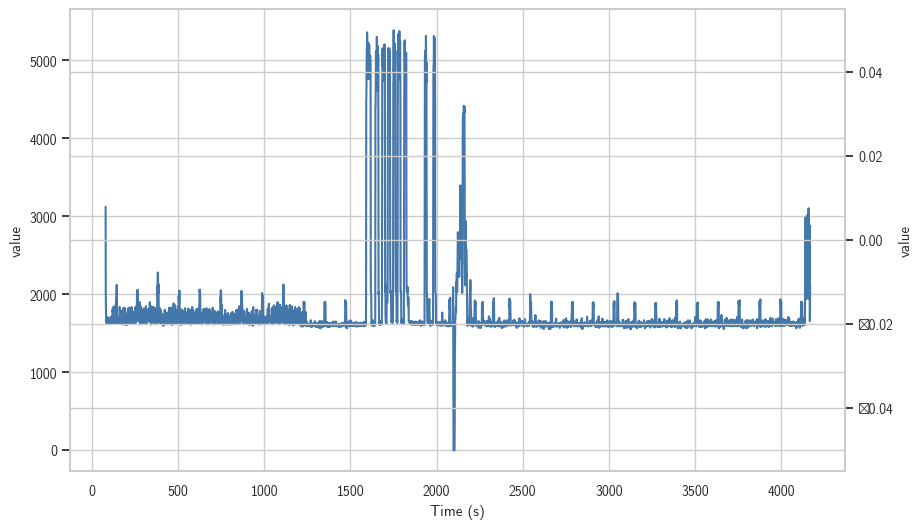

In [13]:
fig, ax = plt.subplots(figsize=(10, 6))

ax2 = ax.twinx()

sns.lineplot(data=df[df["type"] == "rpi_mW"], x="reltime", y="value", ax=ax)
sns.lineplot(data=df[df["type"] == "len_fq"], x="reltime", y="value", ax=ax2, color='r')
ax.set_xlabel("Time (s)")

Text(0.5, 0, 'Time (s)')

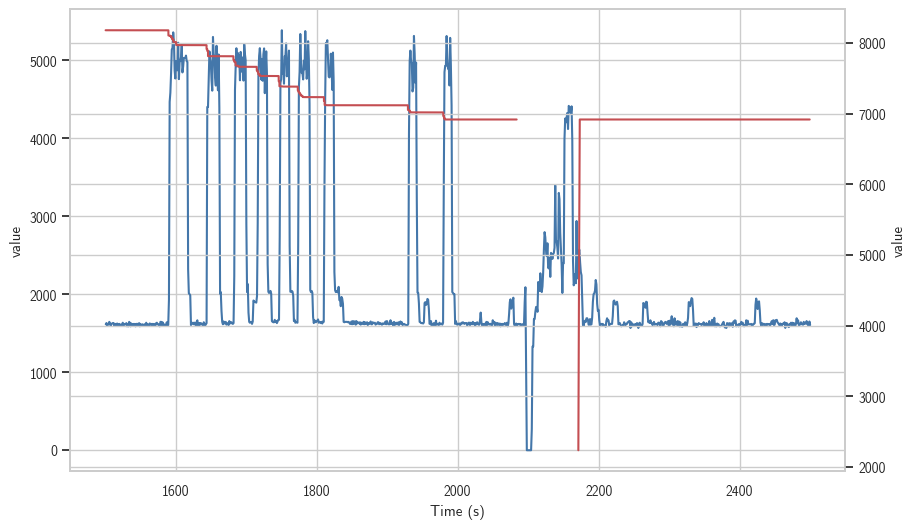

In [14]:
fig, ax = plt.subplots(figsize=(10, 6))

ax2 = ax.twinx()

MIN_T = 1500
MAX_T = 2500

local_df = df[(df["reltime"] > MIN_T) & (df["reltime"] < MAX_T)]

rpi_data = local_df[local_df["type"] == "rpi_mW"]
len_fq_before_data = local_df[local_df["type"] == "len_fq-before"]
len_fq_after_data = local_df[local_df["type"] == "len_fq-after"]

sns.lineplot(data=rpi_data, x="reltime", y="value", ax=ax)
sns.lineplot(data=len_fq_before_data, x="reltime", y="value", ax=ax2, color='r')
sns.lineplot(data=len_fq_after_data, x="reltime", y="value", ax=ax2, color='r')
ax.set_xlabel("Time (s)")

Text(0.5, 0, 'Time (s)')

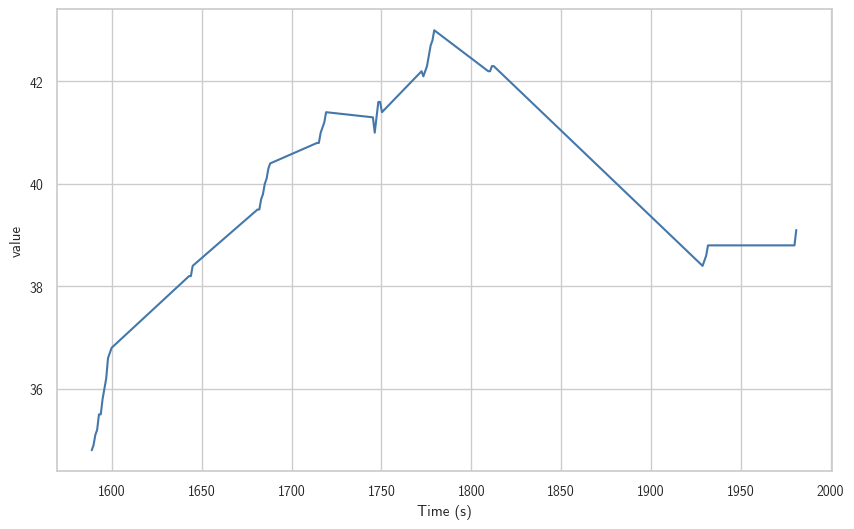

In [15]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.lineplot(data=df[df["type"] == "temp_C"], x="reltime", y="value", ax=ax, estimator=None)
ax.set_xlabel("Time (s)")

/var/folders/2f/b2y6thfs2051_m0fs57vb_sc0000gn/T/ipykernel_72708/2237345819.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  battery_data["value"] = battery_data["value"]/BATTERY*100


Text(0.5, 0, 'Time (s)')

/Users/tobias/Uni/git/project-spencer/trabant/.venv/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)
/Users/tobias/Uni/git/project-spencer/trabant/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


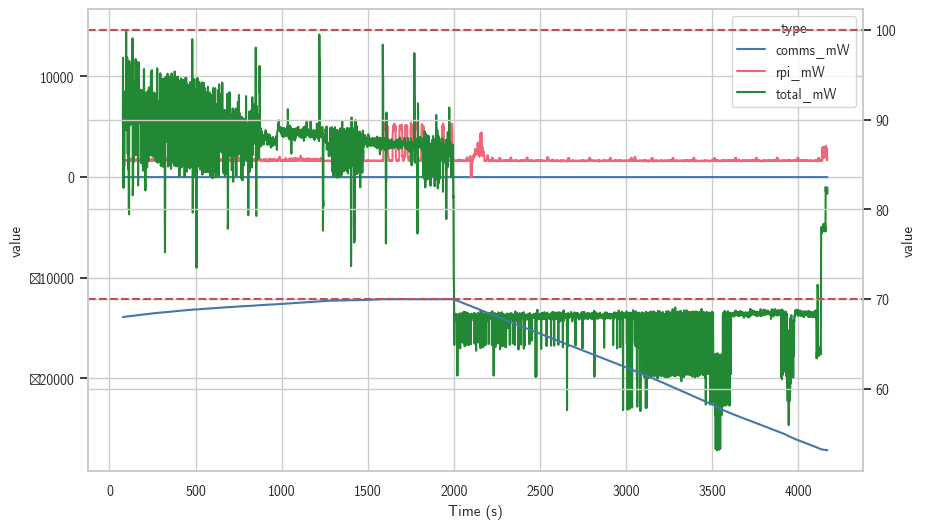

In [16]:
fig, ax = plt.subplots(figsize=(10, 6))
ax2 = ax.twinx()
BATTERY = 57.5 * 1e3

energy_data = df[(df["type"] == "total_mW") | (df["type"] == "comms_mW") | (df["type"] == "rpi_mW")]
sns.lineplot(data=energy_data, x="reltime", y="value", ax=ax, hue="type")

battery_data = df[df["type"] == "battery_mWh"]
battery_data["value"] = battery_data["value"]/BATTERY*100

sns.lineplot(data=battery_data, x="reltime", y="value", ax=ax2)
ax2.axhline(y=100, color='r', linestyle='--')
ax2.axhline(y=70, color='r', linestyle='--')

# ax.legend(["Solar", "Comms", "RPi", "Sat"], loc='upper left')
ax.set_xlabel("Time (s)")

/var/folders/2f/b2y6thfs2051_m0fs57vb_sc0000gn/T/ipykernel_72708/213088392.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  len_fq_before_data.loc[len_fq_before_data.index.max()+1] = {"reltime": interrupt_time, "value": len_fq_before_data.loc[len_fq_before_data.index.max()]["value"]}
/var/folders/2f/b2y6thfs2051_m0fs57vb_sc0000gn/T/ipykernel_72708/213088392.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  len_fq_before_data.loc[len_fq_before_data.index.max()+1] = {"reltime": interrupt_time, "value": len_fq_before_data.loc[len_fq_before_data.index.ma

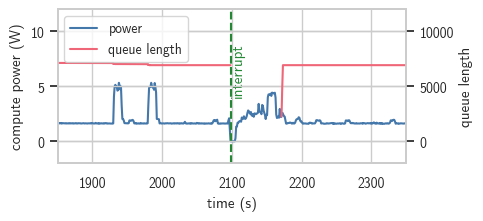

In [17]:
MIN_T = 1850
MAX_T = 2350

local_df = df[(df["reltime"] > MIN_T) & (df["reltime"] < MAX_T)]

rpi_data = local_df[local_df["type"] == "rpi_mW"].copy()
rpi_data["value"] = rpi_data["value"] / 1e3
len_fq_before_data = local_df[local_df["type"] == "len_fq-before"]
len_fq_after_data = local_df[local_df["type"] == "len_fq-after"]

interrupt_time = rpi_data[rpi_data["value"] == 0.0].iloc[0]["reltime"]

# add a data point for queue size at the interrupt
len_fq_before_data.loc[len_fq_before_data.index.max()+1] = {"reltime": interrupt_time, "value": len_fq_before_data.loc[len_fq_before_data.index.max()]["value"]}

fig, ax = plt.subplots(figsize=(4.5, 2))
ax2 = ax.twinx()

sns.lineplot(data=rpi_data, x="reltime", y="value", ax=ax, color=pal[0], estimator=None)
sns.lineplot(data=len_fq_before_data, x="reltime", y="value", ax=ax2, color=pal[1], estimator=None)
sns.lineplot(data=len_fq_after_data, x="reltime", y="value", ax=ax2, color=pal[1], estimator=None)

# add a line for the interrupt
ax.axvline(x=interrupt_time, color=pal[2], linestyle='--')
# add some text
ax.text(interrupt_time, 9, "interrupt", rotation=90, verticalalignment='top', color=pal[2])

ax.set_xlabel("time (s)")
ax.set_xlim(MIN_T, MAX_T)
ax.set(ylim=(-2, 12))
ax2.set(ylim=(-2000, 12_000))
ax.set_ylabel("compute power (W)")
ax2.set_ylabel("queue length")

handles, labels = ax2.get_legend_handles_labels()
handles.append(mpl.lines.Line2D([0], [0], color=pal[0]))
labels.append("power")
handles.append(mpl.lines.Line2D([0], [0], color=pal[1]))
labels.append("queue length")

ax2.legend(handles=handles, labels=labels, loc='upper left')

plt.savefig("reset-interrupt.pdf", bbox_inches='tight')